# 546 (Optimization for Learning and Control) hw2

You are welcome (and encouraged) to work with others, but each individual must submit their own writeup.

You are welcome to use your preferred computational toolkit -- upload the **commented** sourcecode alongside your writeup (e.g. the .ipynb file).

You are welcome to consult research articles and other materials -- upload a .pdf of the article alongside your writeup and indicate which references were used where in the writeup.

In [2]:
import numpy as np
import pylab as plt
from scipy import linalg as la
import scipy.stats as stats
%matplotlib inline
import matplotlib.pylab as plt

## linear quadratic regulation (16 pts)

Consider the discrete-time linear quadratic regulator problem (DT-LQR)

$$\min_u c_\tau (x,u) \ \text{s.t.} \ x_{s+1} = A_s x_s + B_s u_s,$$
$$c_\tau(x,u) = \frac{1}{2} x_t^\top P_t x_t + \frac{1}{2}\sum_{s=\tau}^{t-1} x_s^\top Q_s x_s + u_s^\top R_s u_s$$

where $P_t$, $\{Q_s\}_{s=\tau}^{t-1}$, $\{R_s\}_{s=\tau}^{t-1}$ are given symmetric positive-definite matrices.

In this problem, you'll apply Bellman's dynamic programming principle to determine the optimal control, then verify this control is the same one obtained by a descent algorithm.

a. Determine the optimal control and value at time $\tau = t$ (i.e. minimize $c_t$ with respect to $u_t$, and let $v^*_t = c_t(x^*,u^*)$ denote the optimal value that can be obtained at time $t$).

(See lecture note on dynamic programming & LQR). 
At the final time $\tau = t$, since the final cost is $c_t = \frac{1}{2} x_t^{\top} P_t x_t$, 

the optimal control is $u_t^{*} = 0$ 

and optimal value is $v_t^{*} = \frac{1}{2} x_t^{\top} P_t x_t$.

b. Determine the optimal control and value at time $\tau = t-1$ (i.e. minimize $c_{t-1}$ with respect to $u_{t-1}$, and let $v^*_{t-1} = c_{t-1}(x^*,u^*)$ denote the optimal value that can be obtained at time $t-1$).

(See lecture note on dynamic programming & LQR). 

The optimal control is $u_{t-1}^{*} = - K_{t-1} x_{t-1}$, where $K_{t-1} = (B_{t-1}^\top P_t B_{t-1} + R_{t-1})^{-1} B_{t-1}^\top P_t A_{t-1}$.

The optimal value is $v_{t-1}^{*} = \frac{1}{2} x_{t-1}^\top P_{t-1}x_{t-1}$, where $P_{t-1} = (A_{t-1} - B_{t-1} K_{t-1})^\top P_t (A_{t-1} - B_{t-1} K_{t-1}) + K_{t-1}^\top R_{t-1} K_{t-1} + Q_{t-1}$.

c. Note that the optimal control is linear in state and the optimal value is quadratic in state (i.e. determine $K_{t-1}$ and $P_{t-1}$ such that $u_{t-1} = K_{t-1} x_{t-1}$ and $v^*_{t-1} = c_{t-1}(x^*,u^*) = x_{t-1}^T P_{t-1} x_{t-1}$).

d. Use the substitution in (c.) to generalize the calculation in (b.) to derive a recursive formula to compute the optimal control and value at any time $s\in [\tau,t]$.

(See lecture note on dynamic programming & LQR). A any given time, 

$$K_s = (B_s^\top P_{s+1} B_s + R_s)^{-1} B_s^{\top} P_{s+1} A_s$$
$$P_s = (A_s - B_s K_s)^\top P_{s+1} (A_s - B_s K_s) + K_s^\top R_s K_s + Q_s$$

The optimal control is $u_s^{*} = - K_s x_s$.

The optimal value is $v_s^{*} = \frac{1}{2} x_s^\top P_s x_s$.

e. Implement the recursion in (d.) numerically for the following system, which is a discretized linear spring-mass-damper (let $\kappa,\beta,q,r,\Delta > 0$ be parameters that you can easily vary in your implementation):

$$A^\Delta = I + \Delta \left[\begin{array}{cc} 0 & 1 \\ -\kappa & -\beta \end{array}\right],\ B^\Delta = \Delta \left[\begin{array}{c} 0 \\ 1 \end{array}\right],\ P_t = 0,\ Q^\Delta_s = q \cdot \Delta \cdot I,\ R^\Delta_s = r \cdot \Delta \cdot I.$$

In [48]:
i = []
for s in range(t)[::-1][1:]:
    i.append(s)
i

[8, 7, 6, 5, 4, 3, 2, 1, 0]

In [95]:
delta = 1e-1
k = 1 #kappa
b = 1 #beta
q = 1
r = 1
t = 20 #total time

n = 2 #state dimensions
m = 1 #input dimensions

A = np.eye(n) + delta*np.array([[0,1],[-k,-b]])
B = delta*np.array([[0],[1]])
Q = q*delta*np.eye(n)
R = r*delta*np.eye(m)
Pt = np.zeros((n,n)) # P at final t

def LQR(A,B,Q,R,Pt,t):
    K = np.zeros((t,m,n))
    P = np.zeros((t,n,n))
    P[-1] = Pt

    for s in range(t)[::-1][1:]:#backward in time from 8~0
        K[s] = la.inv(B.T@P[s+1]@B + R) @ B.T @P[s+1] @ A 
        P[s] = (A-B@K[s]).T @ P[s+1] @ (A-B@K[s]) + K[s].T @ R @ K[s] + Q

    return K,P

f. Investigate how the optimal controls vary with respect to the ratio $q/r$ (i.e. let $q/r$ range from $0.1$ to $10$, compute the optimal control input, describe the trend you observe, and provide a visualization that clearly illustrates this trend).

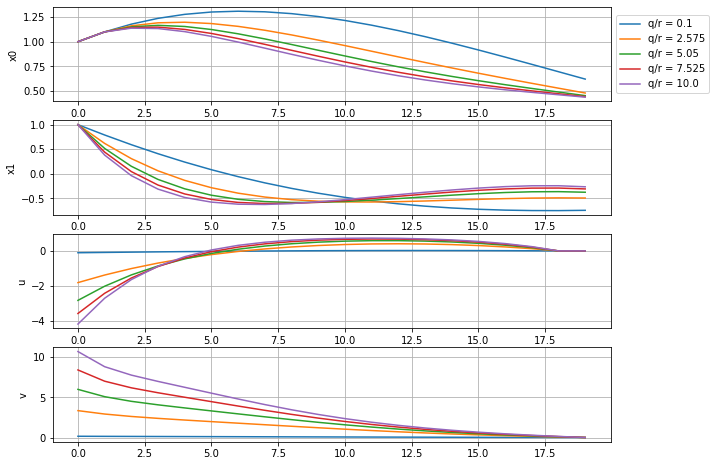

In [118]:
# intial condition x0
x0 = np.array([[1],[1]])

#states of all time
x = np.zeros((t,n,1))
x[0] = x0

#control input & value of all times
u = np.zeros((t,m)) #control input u = -Kx
v = np.zeros((t,m)) 

#all time 
t_ = np.linspace(0,t-1,t)

fig,axs = plt.subplots(4,1,figsize = (10,8))

qr_ratio_list = np.linspace(0.1,10,5)
for qr_ratio in qr_ratio_list:
    r = 1
    q = r*qr_ratio
    Q = q*delta*np.eye(n)
    R = r*delta*np.eye(m)
    K,P = LQR(A,B,Q,R,Pt,t) #K,P at all time

    for s in range(t-1): #forward in time 0~8
        u[s] = -K[s]@x[s] #optimal input
        x[s+1] = A@x[s] + B*u[s] #state
        v[s] = 0.5*(x[s].T@P[s]@x[s])#optimal value (cost-to-go)
    axs[0].plot(t_,x[:,0],label = 'q/r = '+str(qr_ratio))
    axs[1].plot(t_,x[:,1],label = 'q/r = '+str(qr_ratio))
    axs[2].plot(t_,u,label = 'q/r = '+str(qr_ratio))
    axs[3].plot(t_,v,label = 'q/r = '+str(qr_ratio))


axs[0].set_ylabel('x0')
axs[1].set_ylabel('x1')
axs[2].set_ylabel('u')
axs[3].set_ylabel('v')

axs[0].legend(loc="center left", bbox_to_anchor=(1,0.5))

axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()

plt.show()


g. Verify your implementation in (e.) by applying a descent algorithm to approximate the optimal input on time horizon $t = 10\cdot\Delta$ and $t = 100\cdot\Delta$ for the following initial conditions with $\kappa,\beta,q,r = 1$, $\Delta = 0.1$:

$$x_1 = (1,0),\ x_2 = (0,1).$$

***Hint:*** you can directly apply ***simple random search***, or use ***finite differences*** to approximate the gradient.  To apply ***steepest descent*** or ***Newton-Raphson***, you'll need to analytically differentiate the cost with respect to the control input applied at each timestep.


In [ ]:
delta = 0.1
k = 1 #kappa
b = 1 #beta
q = 1
r = 1

A = np.eye(n) + delta*np.array([[0,1],[-k,-b]])
B = delta*np.array([[0],[1]])
Q = q*delta*np.eye(n)
R = r*delta*np.eye(m)
Pt = np.zeros((n,n)) # P at final t


x0 = np.array([[1],[0]])
t = 10*delta





***Bonus:*** analytically differentiate the cost with respect to the control input applied at each timestep one or two times to implement ***steepest descent*** or ***Newton-Raphson*** algorithms to approximate the optimal control.

h. Now consider the infinite time-horizon problem with time-invariant dynamics:

$$\min_u c(x,u) \ \text{s.t.} \ x_{s+1} = A x_s + B u_s,$$
$$c(x,u) = \frac{1}{2}\sum_{s=0}^{\infty} x_s^\top Q x_s + u_s^\top R u_s,$$

where $A$, $B$, $Q$, and $R$ do not vary in time.  Noting that the system from (e.) is time-invariant, solve the LQR problem on an "infinite" time horizon:  iterate the recursion from (d.) many times and plot the entries of the $P$ matrix versus iteration number.  Compare with the result obtained from solving the ***discrete algebraic Riccati equation***

$$ X = (A - B K)^\top X (A - B K) + K^\top R K + Q,\ K = (B^\top X B + R)^{-1} B^\top X A $$

using the `solve_discrete_are` routine from the `scipy.linalg` module ***or*** the `dare` routine from the `python-control` module (execute `!pip install python-control` in Colab to make this module available).

# paper presentation (8pts)

Recall that you will review and present a paper as part of this class; these elements are worth 30% of the grade.  More details and guidelines are provided on the course Syllabus.
  
***You must obtain approval for your selected paper prior to submitting this writeup*** -- one third of the credit for this assignment (8/24 points) are earned for selecting an approved paper and entering the paper and presentation information in the shared Google Doc (linked at Canvas -> Collaborations).

The papers provided in the following research literature repository are pre-approved; so long as no one else has claimed the paper when you enter the information in the Google Doc, no further action is needed:
  https://paperpile.com/shared/x8K3ux
  
If you want to present a paper that isn't in the repository, you must send it to Prof Burden to obtain approval.